In [1]:
## import libraries
import sys
import glob
import re

import geopandas as gpd
import cartopy
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import cmocean.cm as cmo
from matplotlib.gridspec import GridSpec

# cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from plotter import draw_basemap, plot_terrain
from utils import roundPartial, select_months_ds
import customcmaps as ccmap

pd.options.display.float_format = "{:,.2f}".format # makes it so pandas tables display only first two decimals

ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/eaton-scripps/share/proj failed


In [2]:
path_to_data = '/data/projects/Comet/cwp140/' 
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
## load watershed shapefile
## use geopandas to import the shapefile
fp = path_to_data + 'downloads/CO_HUC8/wbdhu8.shp'
polys = gpd.read_file(fp, crs="epsg:4326") # have to manually set the projection
HUC8_lst = polys['HUC8'].values
HUC8_lst

array(['14080107', '14080105', '14020005', '14020002', '14050002',
       '13010005', '11020002', '11020006', '11080001', '11020008',
       '10190011', '11020012', '11040002', '10190013', '10190014',
       '10250001', '10250005', '10190018', '14040109', '14010005',
       '14050001', '13020102', '10190005', '10190017', '10250006',
       '14030005', '14030004', '14050003', '11020003', '10190009',
       '10190015', '10190003', '11040001', '10260001', '14080202',
       '14060010', '14040106', '14050007', '14080102', '13010002',
       '11020005', '11020010', '14010001', '10190010', '10190012',
       '11040005', '10250002', '10250012', '13010004', '11020001',
       '14010004', '14010003', '14010002', '10180010', '10190001',
       '10190007', '10190008', '10190016', '11040003', '14020006',
       '14050006', '14050005', '13020101', '11020007', '11020011',
       '14020001', '10180002', '10180001', '11040004', '10250003',
       '14080203', '14080104', '14080101', '14020004', '140200

In [4]:
## load AR scale subbasin data
df_lst = []
tmp_lst = []
for i, HUCID in enumerate(HUC8_lst):
    # print(HUCID)
    path = '/data/projects/AR_Science/ARCatalog/ERA5-CONUSHUC8/AROutput/files/output_{0}.csv'.format(HUCID)
    names = ['start_date', 'end_date', 'other_date', 'duration', 'IVT1', 'AR_scale', 'IVT2', 'IVT3', 'IVT4', 'IVT5', 'IVT6', 'IVT7', 'IVT8']
    drop_names = ['end_date', 'other_date', 'duration', 'IVT1', 'IVT2', 'IVT3', 'IVT4', 'IVT5', 'IVT6', 'IVT7', 'IVT8']
    df = pd.read_csv(path, header=None, names=names)
    df = df.drop(labels=drop_names, axis=1)

    ## we want the count of AR_scale per year

    ## make year a column based on start_date
    try: 
        df = df.set_index(pd.to_datetime(df['start_date'], format='%Y%m%d%H'))
        df['year'] = df.index.year
        df = df.drop(labels=['start_date'], axis=1)

        ## make a column with HUC8ID
        df['HUC8'] = HUCID
        
        ## hack to make sure the HUCID shows up in final table if there are no AR events after 2000
        t = pd.to_datetime('2000010101', format='%Y%m%d%H') 
        df.loc[t] = [0, 2000, HUCID]  # adding a row 

        ## subset to 2000-2023
        idx = (df.index.year > 1999)
        df = df.loc[idx]
        df = df.reset_index()
        
        ## count number of AR scale per year
        
    
        ## append to list
        df_lst.append(df)
    
    except ValueError:
        print(i, HUCID)
        tmp_lst.append(str(HUCID))
        df['HUC8'] = HUCID
        df['year'] = 2000
        df = df.fillna(0)
        df_lst.append(df)
    


3 14020002
22 10190005
42 14010001
48 13010004
49 11020001
50 14010004
51 14010003
52 14010002
54 10190001
65 14020001
73 14020004
74 14020003
77 10190004
86 13010001
87 10190002


In [5]:
# HUCID = '14050001'
# path = '/data/projects/AR_Science/ARCatalog/ERA5-CONUSHUC8/AROutput/files/output_{0}.csv'.format(HUCID)
# df = pd.read_csv(path, header=None, names=names)
# drop_names = ['end_date', 'other_date', 'duration', 'IVT1', 'IVT2', 'IVT3', 'IVT4', 'IVT5', 'IVT6', 'IVT7', 'IVT8']
# df = pd.read_csv(path, header=None, names=names)
# df = df.drop(labels=drop_names, axis=1)

# df = df.set_index(pd.to_datetime(df['start_date'], format='%Y%m%d%H'))
# df['year'] = df.index.year
# df = df.drop(labels=['start_date'], axis=1)

# ## make a column with HUC8ID
# df['HUC8'] = HUCID

# ## hack to make sure the HUCID shows up in final table if there are no AR events after 2000
# t = pd.to_datetime('2000010101', format='%Y%m%d%H') 
# df.loc[t] = [0, 2000, HUCID]  # adding a row 

# ## subset to 2000-2023
# idx = (df.index.year > 1999)
# df = df.loc[idx]
# df = df.reset_index()

# if len(df) == 0:
#     df['AR_scale'] = 0
#     df['year'] = 2000
#     df['HUC8'] = HUCID
   
# df

In [6]:
## now stack resulting dfs into one
df = pd.concat(df_lst)
df = pd.pivot_table(df, values='AR_scale', index=['year', 'HUC8'], columns=['AR_scale'], aggfunc="count") # sum no. ARs per year
df = df.fillna(0) ## fill nans with 0

final_df = df.groupby('HUC8').mean() ## average over the years
final_df

AR_scale,0.00,1.00,2.00,3.00,4.00,5.00
HUC8,,,,,,
10180001,1.00,0.00,0.00,0.00,0.00,0.00
10180002,0.20,0.60,0.20,0.00,0.00,0.00
10180010,0.33,0.67,0.00,0.00,0.00,0.00
10190001,1.00,0.00,0.00,0.00,0.00,0.00
10190002,1.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...
14080105,0.17,0.83,0.00,0.00,0.00,0.00
14080107,0.17,0.83,0.00,0.00,0.00,0.00
14080201,0.08,0.69,0.23,0.08,0.00,0.00


In [7]:
test = final_df.reindex(HUC8_lst)
test

AR_scale,0.00,1.00,2.00,3.00,4.00,5.00
HUC8,,,,,,
14080107,0.17,0.83,0.00,0.00,0.00,0.00
14080105,0.17,0.83,0.00,0.00,0.00,0.00
14020005,0.17,0.83,0.00,0.00,0.00,0.00
14020002,1.00,0.00,0.00,0.00,0.00,0.00
14050002,0.07,1.07,0.13,0.00,0.00,0.00
...,...,...,...,...,...,...
10190002,1.00,0.00,0.00,0.00,0.00,0.00
11020013,0.04,2.21,1.21,0.29,0.04,0.00
11030002,0.04,5.58,2.96,0.96,0.38,0.00


In [8]:
for i, AR in enumerate(range(1, 6)):
    print(AR)
    polys['AR_scale{0}'.format(AR)] = test.iloc[:, AR].values
    
polys

1
2
3
4
5


,OBJECTID,TNMID,MetaSource,SourceData,SourceOrig,SourceFeat,LoadDate,GNIS_ID,AreaAcres,AreaSqKm,...,HUC8,Name,Shape_Leng,Shape_Area,geometry,AR_scale1,AR_scale2,AR_scale3,AR_scale4,AR_scale5
0,1,{75740F8C-AFFA-40B5-908E-4911BCB38D0B},None,None,None,None,2012-06-11,0,"513,247.49","2,077.04",...,14080107,Mancos,2.94,0.21,"POLYGON ((-108.17534 37.49757, -108.17470 37.4...",0.83,0.00,0.00,0.00,0.00
1,2,{9CE10C90-4927-4081-A2DE-D75ACBD9AB0E},None,None,None,None,2012-06-11,0,"1,244,784.87","5,037.47",...,14080105,Middle San Juan,5.29,0.51,"POLYGON ((-108.02906 37.45744, -108.02890 37.4...",0.83,0.00,0.00,0.00,0.00
2,3,{E2E7179D-6D0F-4ACF-834E-5D4374049550},None,None,None,None,2012-06-11,0,"1,064,098.35","4,306.26",...,14020005,Lower Gunnison,4.11,0.45,"POLYGON ((-107.85652 39.07754, -107.85617 39.0...",0.83,0.00,0.00,0.00,0.00
3,4,{4EED71FB-EF76-4C19-AF12-20EB00933CC8},None,None,None,None,2012-06-11,0,"1,543,205.42","6,245.14",...,14020002,Upper Gunnison,5.24,0.64,"POLYGON ((-107.03062 38.83861, -107.03026 38.8...",0.00,0.00,0.00,0.00,0.00
4,5,{86C5C83C-94D7-4D2A-8C7D-FAD6692393E9},None,None,None,None,2012-06-11,0,"1,004,494.10","4,065.05",...,14050002,Lower Yampa,5.19,0.43,"POLYGON ((-107.77363 40.76779, -107.77339 40.7...",1.07,0.13,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,88,{AAFC1326-6A7C-49C0-BC17-9573AE42BC21},None,None,None,None,2016-10-11,0,"1,183,831.16","4,790.80",...,10190002,Upper South Platte,4.29,0.50,"POLYGON ((-105.04506 39.76261, -105.04449 39.7...",0.00,0.00,0.00,0.00,0.00
88,89,{9B76BB5C-5457-44FC-A615-03F4E1E7B6DB},None,None,None,None,2012-06-11,0,"515,946.10","2,087.96",...,11020013,Two Butte,3.87,0.21,"POLYGON ((-102.12829 38.03786, -102.12874 38.0...",2.21,1.21,0.29,0.04,0.00
89,90,{F03AFF73-2581-45A4-8C3B-871527565D2F},None,None,None,None,2012-06-11,0,"932,953.43","3,775.53",...,11030002,Whitewoman,4.18,0.39,"POLYGON ((-102.35287 38.73024, -102.35176 38.7...",5.58,2.96,0.96,0.38,0.00
90,91,{056F412F-FCEA-4073-9F4D-4B9ECE0106D7},None,None,None,None,2012-06-11,0,"1,471,856.04","5,956.40",...,11030001,Middle Arkansas-Lake McKinney,5.25,0.61,"POLYGON ((-102.08766 38.40768, -102.08542 38.4...",6.50,3.62,1.12,0.38,0.04


In [9]:
# Set up projection
datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.PlateCarree() ## the projection you want your map displayed in

# Set tick/grid locations
ext1 = [-111., -100., 35.5, 42.5] # extent of CO
dx = np.arange(ext1[0],ext1[1]+2,2)
dy = np.arange(ext1[2]-.5,ext1[3]+1,1)

# # make a colormap that has land and ocean clearly delineated and of the
# # same length (256 + 256)
# colors_undersea = plt.cm.terrain(np.linspace(0, 0.17, 256))
# colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
# all_colors = np.vstack((colors_undersea, colors_land))
# terrain_map = mcolors.LinearSegmentedColormap.from_list(
#     'terrain_map', all_colors)
# # make the norm:  Note the center is offset so that the land has more
# # dynamic range:
# divnorm = mcolors.TwoSlopeNorm(vmin=-0.25, vcenter=1, vmax=3000)


wc_rgb = (86./255., 105./255., 166./255.) # color for water features
wc_cmyk = (48., 37., 0., 35.)


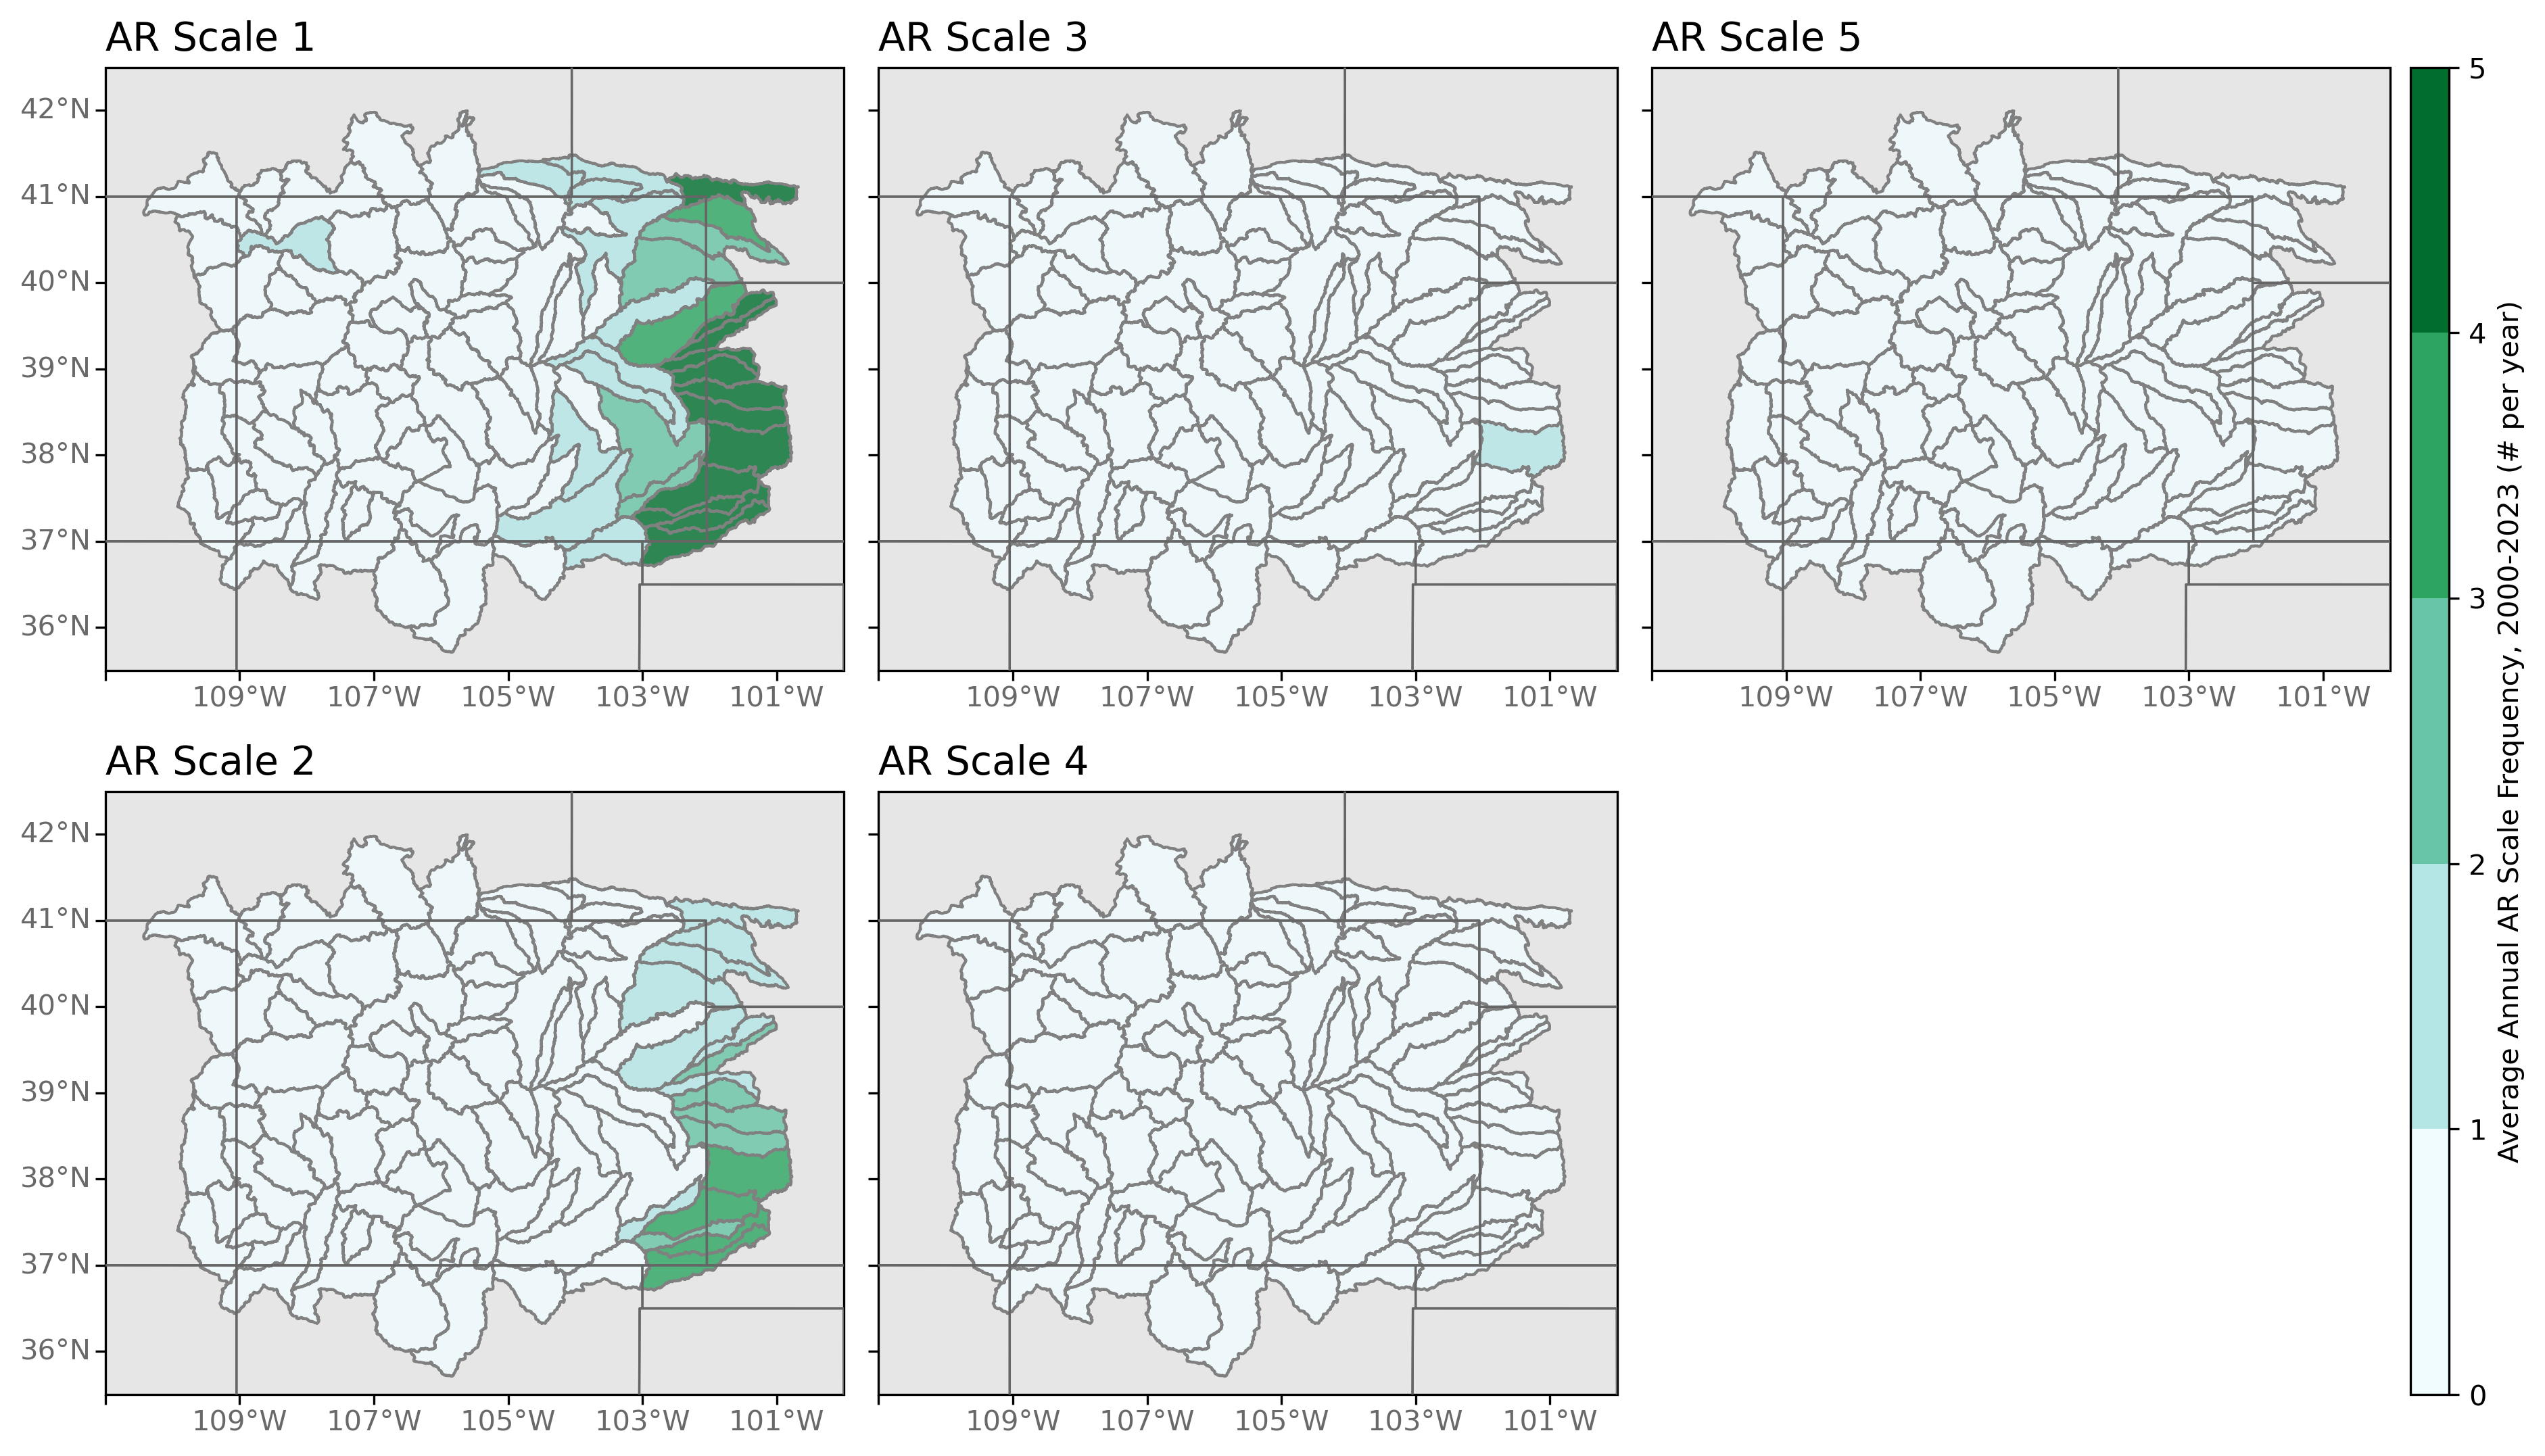

In [10]:
# Create figure
fig = plt.figure(figsize=(15, 8.5))
fig.dpi = 300
fname = path_to_figs + 'avg_annual_ar_scale_freq'
fmt = 'png'

nrows = 2
ncols = 4

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 1], width_ratios = [1, 1, 1, 0.05], wspace=0.01, hspace=0.2)
## use gs[rows index, columns index] to access grids

# Add color bar axis
cbax = plt.subplot(gs[:,-1]) # colorbar axis
var_lst = ['AR_scale1', 'AR_scale2', 'AR_scale3', 'AR_scale4', 'AR_scale5']
lbl_lst = ['AR Scale 1', 'AR Scale 2', 'AR Scale 3', 'AR Scale 4', 'AR Scale 5']
row_idx = [0, 1, 0, 1, 0]
col_idx = [0, 0, 1, 1, 2]
llats_lst = [True, True, False, False, False]

for k, varname in enumerate(var_lst):
    ## Add axis for plot
    ax = fig.add_subplot(gs[row_idx[k],col_idx[k]], projection=mapcrs)
    ax = draw_basemap(ax, extent=ext1, xticks=dx, yticks=dy,left_lats=llats_lst[k], right_lats=False, mask_ocean=False, coastline=False)

    ## topo with gray shading
    # cs = plot_terrain(ax, ext1)

    # add choropleth watershed fraction
    lgnd_kwds={"label": "Average Annual AR Scale Frequency, 2000-2023 (# per year)", "orientation": "vertical"}
    cmap, norm, bnds = ccmap.cmap('ar_freq')
    cf = polys.plot(ax=ax, column=varname, cmap=cmap, vmin=0, vmax=5, norm=norm, alpha=0.8, legend=True, cax=cbax, legend_kwds=lgnd_kwds)
    polys.plot(ax=ax, edgecolor='grey', color='None', zorder=98)

    ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8, zorder=199)

    ## add in four focus watersheds
    # tmp.plot(ax=ax, edgecolor='white', color='None', zorder=99)
    # basin.plot(ax=ax, edgecolor='white', color='None', zorder=99)

    ax.set_title(lbl_lst[k], loc='left', fontsize=14)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()